_This notebook contains code and comments from Section 2.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## Estudio de caso: Diagnóstico de cáncer de mama

Nuestro primer estudio de caso explora una tarea de toma de decisiones médicas: el diagnóstico de cáncer de mama. Veremos cómo usar los módulos de conjuntos paralelos homogéneos de scikit-learn en la práctica. En concreto, entrenaremos y evaluaremos el rendimiento de tres algoritmos paralelos homogéneos, cada uno caracterizado por una aleatoriedad creciente: embolsado con árboles de decisión, bosques aleatorios y ExtraTrees.

El diagnóstico de cáncer de mama es la tarea de clasificar los datos del tumor del paciente en una de dos clases: **maligno** frente a **benigno**. Esta tarea (y tareas médicas similares) están en el centro de los **sistemas de apoyo a la toma de decisiones de diagnóstico médico** que están comenzando a tener un uso más amplio en la industria de la salud. Dichos algoritmos de aprendizaje automático pueden minimizar en gran medida la tasa de falsos negativos (donde los pacientes que tienen cáncer son diagnosticados erróneamente hasta que es demasiado tarde) y mejorar las posibilidades de tratamiento y supervivencia.

Esta tarea es desafiante debido a las sutiles variaciones en los datos del paciente, lo que hace que sea muy difícil que un solo modelo logre un alto rendimiento. Los bosques aleatorios y de embolsado pueden aprender modelos efectivos. Este estudio de caso se abordará utilizando las implementaciones de embolsado y bosques aleatorios de scikit-learn. El rendimiento de estos modelos de conjuntos aprendidos se comparará con modelos de aprendizaje automático individuales (no conjuntos/tradicionales). Los resultados se utilizarán para mostrar que los métodos de conjunto pueden superar significativamente a los modelos individuales, lo que brindará al lector un ejemplo concreto y real de cómo los conjuntos pueden tener éxito.

---


### Carga y preprocesamiento

In [2]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

# Convert to a Pandas DataFrame so we can visualize nicely
import pandas as pd
import numpy as np
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
i = np.random.permutation(len(dataset['target']))
df = df.iloc[i, :7]
df['diagnosis'] = dataset['target'][i]
df = df.reset_index()
df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,diagnosis
0,242,11.30,18.19,73.93,389.4,0.09592,0.13250,0.15480,1
1,121,18.66,17.12,121.40,1077.0,0.10540,0.11000,0.14570,0
2,102,12.18,20.52,77.22,458.7,0.08013,0.04038,0.02383,1
3,253,17.30,17.08,113.00,928.2,0.10080,0.10410,0.12660,0
4,171,13.43,19.63,85.84,565.4,0.09048,0.06288,0.05858,0


Procese previamente los datos estandarizando las características para que tengan media cero y desviación estándar unitaria.

In [3]:
X, y = dataset['data'], dataset['target']
# X = StandardScaler().fit_transform(X)  # Never pre-processing as it leads to data leakage
rng=np.random.RandomState(seed=4190)     # Initialize a random number generator 

---

### Embolsado (Bagging), Random Forest y ExtraTrees

Una vez que hayamos preprocesado nuestro conjunto de datos, entrenaremos y evaluaremos el empaquetamiento con árboles de decisión, bosques aleatorios y ExtraTrees para responder las siguientes preguntas:
1. ¿Cómo cambia la interpretación del conjunto con el tamaño del conjunto? Es decir, ¿qué sucede cuando nuestros conjuntos se hacen cada vez más grandes?
2. ¿Cómo cambia la interpretación del conjunto con la complejidad del alumno básico? Es decir, qué sucede cuando nuestros estimadores de base individuales se vuelven cada vez más complejos. En este estudio de caso, dado que los tres métodos de conjunto considerados utilizan árboles de decisión como estimadores base, una "medida" de complejidad es la profundidad del árbol, siendo más complejos los árboles más profundos.

#### Tamaño del conjunto frente a interpretación del conjunto
Comparamos el comportamiento de los tres algoritmos a medida que aumenta el parámetro ``n_estimators``.

**Apartado 2.5**: Buscamos errores de entrenamiento y prueba al aumentar el tamaño del conjunto.

**PRECAUCIÓN: ¡Este experimento a continuación funciona lentamente! Se incluyen archivos Pickle de una ejecución anterior para un trazado rápido.**

In [4]:
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

if not os.path.exists('./data/ErrorVsNumEstimators.pickle'):
    max_leaf_nodes = 8
    n_runs = 20
    n_estimator_range = range(2, 20, 1)

    bag_trn_error = np.zeros((n_runs, len(n_estimator_range)))  # Train error for the bagging classifier
    rf_trn_error = np.zeros((n_runs, len(n_estimator_range)))   # Train error for the random forest classifier
    xt_trn_error = np.zeros((n_runs, len(n_estimator_range)))   # Train error for the extra trees classifier

    bag_tst_error = np.zeros((n_runs, len(n_estimator_range)))  # Test error for the bagging classifier
    rf_tst_error = np.zeros((n_runs, len(n_estimator_range)))   # Test error for the random forest classifier
    xt_tst_error = np.zeros((n_runs, len(n_estimator_range)))   # Test error for the extra trees classifier

    for run in range(0, n_runs):
        print('Run {0}'.format(run))

        # Split into train and test sets
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.25, random_state=rng)

        for j, n_estimators in enumerate(n_estimator_range):
            # Train using bagging
            bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                                        n_estimators=n_estimators, max_samples=0.5, n_jobs=-1, random_state=rng)
            bag_clf.fit(X_trn, y_trn)
            bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
            bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

            # Train using random forests
            rf_clf = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                            n_estimators=n_estimators, n_jobs=-1)
            rf_clf.fit(X_trn, y_trn)
            rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
            rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

            # Train using extra trees
            xt_clf = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, bootstrap=True,
                                          n_estimators=n_estimators, n_jobs=-1, random_state=rng)
            xt_clf.fit(X_trn, y_trn)
            xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
            xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))

        results = (bag_trn_error, bag_tst_error, \
                   rf_trn_error, rf_tst_error, \
                   xt_trn_error, xt_tst_error)

    with open('./data/ErrorVsNumEstimators.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)
        
else:
    with open('./data/ErrorVsNumEstimators.pickle', 'rb') as result_file:
        (bag_trn_error, bag_tst_error, \
         rf_trn_error, rf_tst_error, \
         xt_trn_error, xt_tst_error) = pickle.load(result_file)

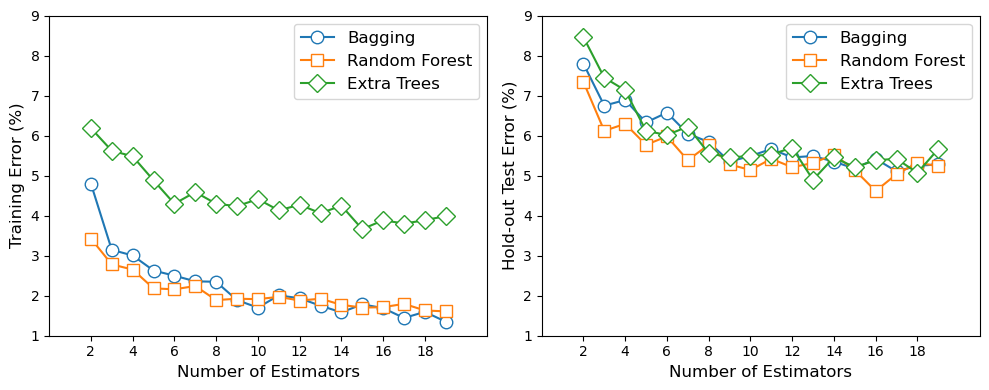

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_estimator_range = range(2, 20, 1)

# Plot the training error
m = np.mean(bag_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[0].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[0].set_xlabel('Number of Estimators', fontsize=12)
ax[0].set_ylabel('Training Error (%)', fontsize=12)
ax[0].set_xticks(range(2, 20, 2))
ax[0].axis([0, 21, 1, 9])
# ax[0].grid()

# Plot the test error
m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[1].set_xlabel('Number of Estimators', fontsize=12)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=12)
# ax[1].grid()
ax[1].set_xticks(range(2, 20, 2))
ax[1].axis([0, 21, 1, 9]);
plt.tight_layout()

# plt.savefig('./figures/CH02_F11_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');
# plt.savefig('./figures/CH02_F11_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight');

#### Complejidad básica del alumno frente a rendimiento del conjunto
A continuación, comparamos el comportamiento de los tres algoritmos a medida que aumenta la complejidad de los alumnos base. Hay varias formas de controlar la complejidad de los árboles de decisión básicos: profundidad máxima, número máximo de nodos hoja, criterios de impureza, etc. Aquí, comparamos el rendimiento de los tres métodos de conjunto con la complejidad determinada por ``max_leaf_nodes``.

**Oculto**: compare el rendimiento del embolsado, los bosques aleatorios y los árboles adicionales en el conjunto de datos de cáncer de mama con el aumento del tamaño de la bolsa. El número máximo de estimadores se fija en 10, lo que garantiza que los tres métodos de conjunto tengan el mismo número de estimadores en el conjunto.

**PRECAUCIÓN: ¡Este experimento a continuación funciona lentamente! Se incluyen archivos Pickle de una ejecución anterior para un trazado rápido.**

In [6]:
# See if the result file for this experiment already exists, and if not, rerun and save
# a new set of results
if not os.path.exists('./data/ErrorVsNumLeaves.pickle'):
    n_estimators = 10
    max_leaf_nodes = 8
    n_runs = 20
    n_leaf_range = [2, 4, 8, 16, 24, 32]

    bag_trn_error = np.zeros((n_runs, len(n_leaf_range)))  # Train error for the bagging classifier
    rf_trn_error = np.zeros((n_runs, len(n_leaf_range)))   # Train error for the random forest classifier
    xt_trn_error = np.zeros((n_runs, len(n_leaf_range)))   # Train error for the extra trees classifier

    bag_tst_error = np.zeros((n_runs, len(n_leaf_range)))  # Test error for the bagging classifier
    rf_tst_error = np.zeros((n_runs, len(n_leaf_range)))   # Test error for the random forest classifier
    xt_tst_error = np.zeros((n_runs, len(n_leaf_range)))   # Test error for the extra trees classifier

    for run in range(0, n_runs):
        print('Run {0}'.format(run))

        # Split into train and test sets
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.25, random_state=rng)

        for j, max_leaf_nodes in enumerate(n_leaf_range):
            # Train using bagging
            bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                                        n_estimators=n_estimators, max_samples=0.5, n_jobs=-1, random_state=rng)
            bag_clf.fit(X_trn, y_trn)
            bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
            bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

            # Train using random forests
            rf_clf = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                            n_estimators=n_estimators, n_jobs=-1, random_state=rng)
            rf_clf.fit(X_trn, y_trn)
            rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
            rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

            # Train using extra trees
            xt_clf = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, bootstrap=True,
                                          n_estimators=n_estimators, n_jobs=-1, random_state=rng)
            xt_clf.fit(X_trn, y_trn)
            xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
            xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))
            
        results = (bag_trn_error, bag_tst_error, \
                   rf_trn_error, rf_tst_error, \
                   xt_trn_error, xt_tst_error)
            
    with open('./data/ErrorVsNumLeaves.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)
        
else:
    with open('./data/ErrorVsNumLeaves.pickle', 'rb') as result_file:
        (bag_trn_error, bag_tst_error, \
         rf_trn_error, rf_tst_error, \
         xt_trn_error, xt_tst_error) = pickle.load(result_file)

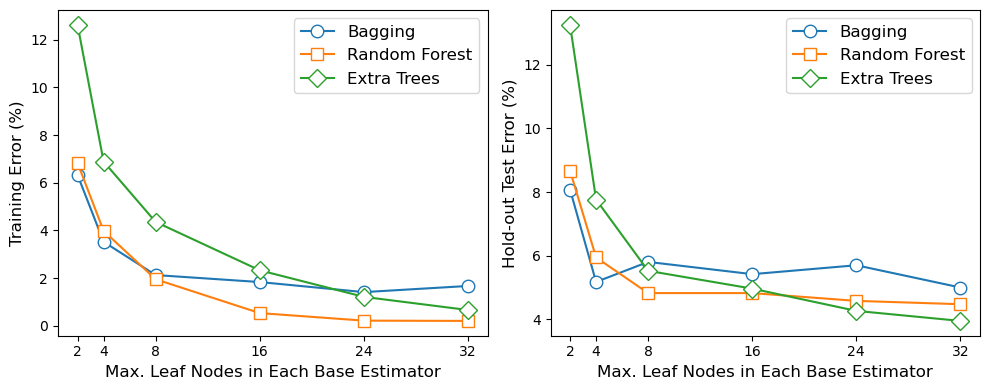

In [7]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_leaf_range = [2, 4, 8, 16, 24, 32]

# Plot the training error
m = np.mean(bag_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[0].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[0].set_xlabel('Max. Leaf Nodes in Each Base Estimator', fontsize=12)
ax[0].set_ylabel('Training Error (%)', fontsize=12)
ax[0].set_xticks(n_leaf_range)
# ax[0].grid()

# Plot the test error
m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[1].set_xlabel('Max. Leaf Nodes in Each Base Estimator', fontsize=12)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=12)
ax[1].set_xticks(n_leaf_range)
# ax[1].grid();
plt.tight_layout()

# plt.savefig('./figures/CH02_F12_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');
# plt.savefig('./figures/CH02_F12_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight');

---

### Importancia de las funciones con Random Forests

Finalmente, vemos cómo podemos usar la importancia de las características para identificar las características más predictivas para el diagnóstico de cáncer de mama usando el conjunto de bosques aleatorios. Dicho análisis agrega interpretabilidad al modelo y puede ser muy útil para comunicar y explicar dichos modelos a expertos en el campo, como los médicos.

#### Importancia de las características con correlaciones de etiquetas
Primero, echemos un vistazo al conjunto de datos para ver si podemos descubrir algunas relaciones interesantes entre las características y el diagnóstico. Este tipo de análisis es típico cuando obtenemos un nuevo conjunto de datos, ya que tratamos de aprender más sobre él. Aquí, nuestro análisis intentará identificar qué características están más correlacionadas entre sí y con el diagnóstico (etiqueta), para que podamos verificar si los bosques aleatorios pueden hacer algo similar.

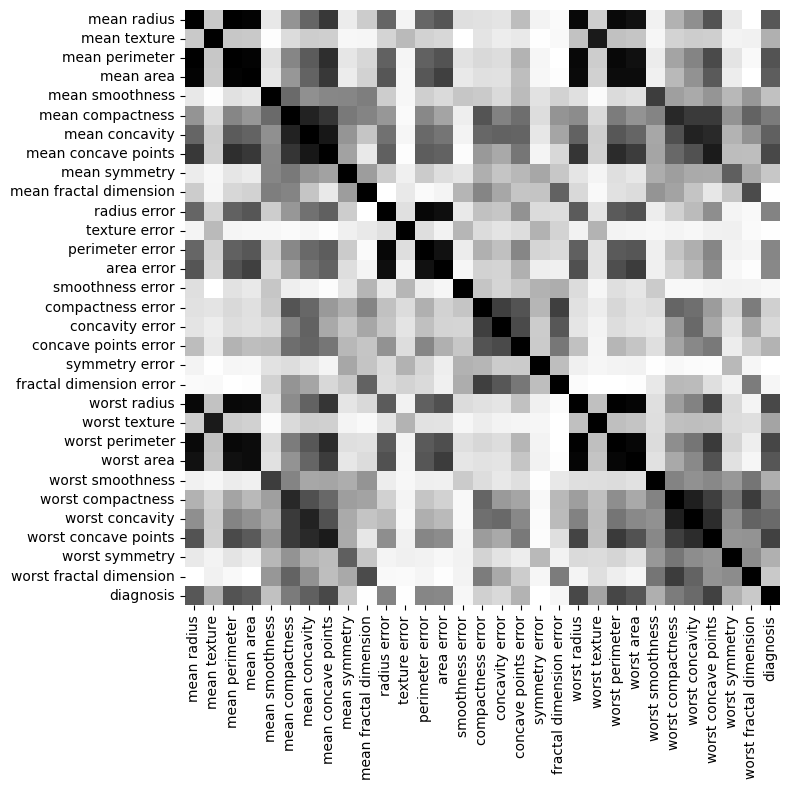

In [8]:
import pandas as pd
import seaborn as sea

df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
df['diagnosis'] = dataset['target'] 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
cor = np.abs(df.corr())
sea.heatmap(cor, annot=False, cbar=False, cmap=plt.cm.Greys, ax=ax)
fig.tight_layout()

# plt.savefig('./figures/CH02_F13_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');
# plt.savefig('./figures/CH02_F13_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight');

Hay varias características que también están altamente correlacionadas con la etiqueta, es decir, el diagnóstico como benigno o maligno. Identifiquemos las 10 características más correlacionadas con la etiqueta de diagnóstico.

In [9]:
label_corr = cor.iloc[:, -1]
label_corr.sort_values(ascending=False)[1:11]

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
Name: diagnosis, dtype: float64

#### Importancias de las características usando bosques aleatorios
Los bosques aleatorios también pueden proporcionar características importantes. La siguiente lista ilustra esto.

**Apartado 2.7**: Importancia de las características en el conjunto de datos WDBC usando bosques aleatorios

In [10]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.15)
n_features = X_trn.shape[1]

rf = RandomForestClassifier(max_leaf_nodes=24, n_estimators=50, n_jobs=-1)
rf.fit(X_trn, y_trn)
err = 1 - accuracy_score(y_tst, rf.predict(X_tst))
print('Prediction Error = {0:4.2f}%'.format(err*100))

importance_threshold = 0.02
for i, (feature, importance) in enumerate(zip(dataset['feature_names'],
                                              rf.feature_importances_)):

    if importance > importance_threshold:
        print('[{0}] {1} (score={2:4.3f})'.format(i, feature, importance))

Prediction Error = 3.49%
[0] mean radius (score=0.082)
[2] mean perimeter (score=0.079)
[3] mean area (score=0.024)
[6] mean concavity (score=0.045)
[7] mean concave points (score=0.143)
[13] area error (score=0.022)
[20] worst radius (score=0.075)
[21] worst texture (score=0.026)
[22] worst perimeter (score=0.107)
[23] worst area (score=0.149)
[26] worst concavity (score=0.027)
[27] worst concave points (score=0.097)


Podemos trazar las importancias de las características identificadas por el conjunto de bosques aleatorios

[0] mean radius (score=0.082)
[2] mean perimeter (score=0.079)
[3] mean area (score=0.024)
[6] mean concavity (score=0.045)
[7] mean concave points (score=0.143)
[13] area error (score=0.022)
[20] worst radius (score=0.075)
[21] worst texture (score=0.026)
[22] worst perimeter (score=0.107)
[23] worst area (score=0.149)
[26] worst concavity (score=0.027)
[27] worst concave points (score=0.097)


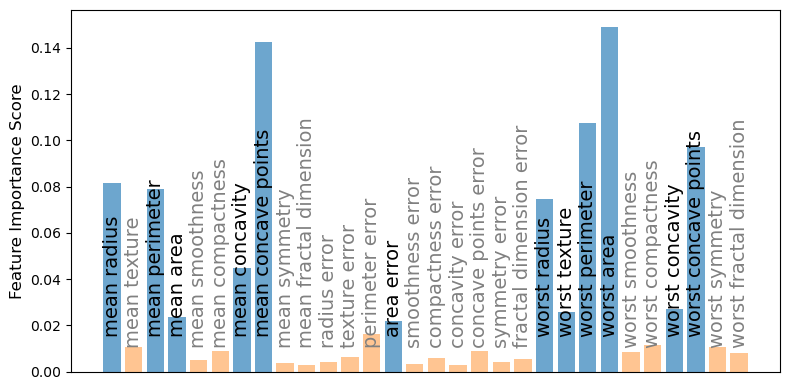

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Identify the important features
importance_threshold = 0.02
idx = np.array(range(n_features))
imp = np.where(rf.feature_importances_ >= importance_threshold)  # important features
rest = np.setdiff1d(idx, imp)  # remaining features

# Plot the important features and the rest on a bar chart
plt.bar(idx[imp], rf.feature_importances_[imp], alpha=0.65)
plt.bar(idx[rest], rf.feature_importances_[rest], alpha=0.45)

# Print feature names on the bar chart
for i, (feature, importance) in enumerate(zip(dataset['feature_names'], rf.feature_importances_)):
    if importance > importance_threshold:
        plt.text(i, 0.015, feature, ha='center', va='bottom', rotation='vertical', fontsize=14)
        print('[{0}] {1} (score={2:4.3f})'.format(i, feature, importance))
    else:
        plt.text(i, 0.01, feature, ha='center', va='bottom', rotation='vertical', fontsize=14, color='gray')
    
# Finish the plot    
fig.axes[0].get_xaxis().set_visible(False)
plt.ylabel('Feature Importance Score', fontsize=12)
plt.xlabel('Features for Breast Cancer Diagnosis', fontsize=12);

plt.tight_layout()
# plt.savefig('./figures/CH02_F14_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');
# plt.savefig('./figures/CH02_F14_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight');